In [1]:
import numpy as np
import pandas as pd

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
#displaying train data
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# 1.Data Cleaning

In [5]:
#dropping location column as there is no relation for disaster msgs with location and removing NaN values
#Dropping the keword column also as the msg will be given to the model to classify not the keyword
train.drop(columns=['location','keyword'],inplace=True)
train = train.dropna()
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


In [7]:
#checking for duplicates
train.duplicated().sum()

0

# 2.EDA

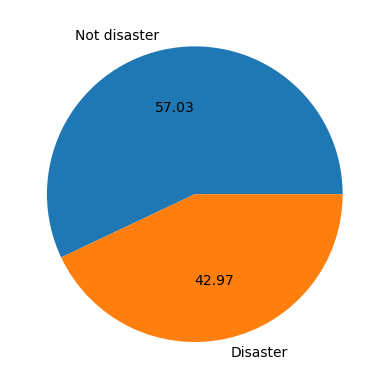

In [8]:
#plotting graph to check the balance in the data
import matplotlib.pyplot as plt
plt.pie(train['target'].value_counts(),labels=['Not disaster','Disaster'],autopct='%.2f')
plt.show()

In [9]:
train['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

# Performing NLP and Data Preprocessing

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import emoji
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
import string

stop_words = set(stopwords.words('english')) 
tk = TweetTokenizer() 
lemmatizer = WordNetLemmatizer()

In [12]:
def transform_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove user mentions
    text = re.sub(r"@\S+", "", text)
    # Remove punctuation
    text = re.sub(f"[{string.punctuation}]", "", text)
    # Remove emojis
    text = emoji.emojize(text, variant='emoji_type')
    # Converting the text to lowercase
    text = text.lower()
    # Tokenize the text
    words = tk.tokenize(text)
    # Lemmatize the text
    words = [lemmatizer.lemmatize(w) for w in words]
    # Remove stop words
    words = [w for w in words if w not in stop_words]
    # Join the tokens back together
    cleaned_text = ' '.join(words)
    
    return cleaned_text

In [13]:
transform_text("more than 2000 families are destroyed in israel-hamaas war")

'2000 family destroyed israelhamaas war'

In [14]:
train['text']=train['text'].apply(transform_text)
train.sample(5)

,id,text,target
5367,7657,plan doe work dont panic bc 25 letter like fee...,0
4440,6318,sent email trinna hold hostage rapping,0
1916,2757,fact curfew,0
5495,7842,reddit quarantine offensive content,0
6443,9218,christian terrorist sure dont suicide bombing ...,1


In [13]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [14]:
disaster_msg= wc.generate(train[train['target']==1]['text'].str.cat(sep=' '))

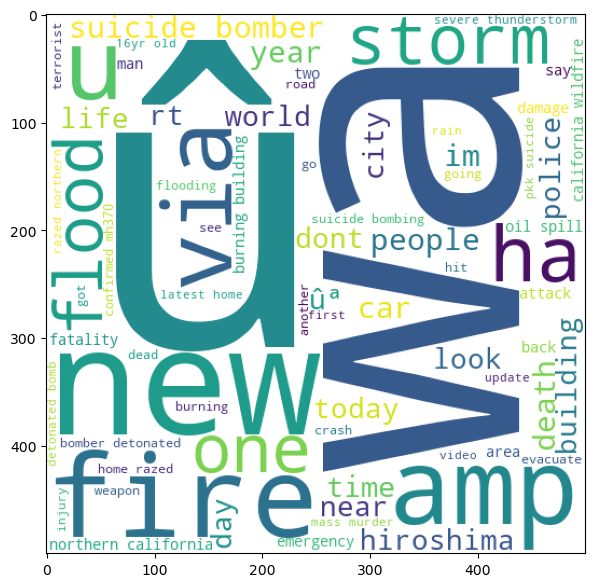

In [15]:
plt.figure(figsize=(7,7))
plt.imshow(disaster_msg)

# Model Training

# Text vectorization

In [45]:
#using BogOfWords
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
cv = CountVectorizer(binary=True,ngram_range=(1,3),max_features=25000)
#Tfidf=TfidfVectorizer(max_features=7000)
Tfidf=TfidfVectorizer(binary=True, sublinear_tf=True,ngram_range=(1,3),max_features=25000)

In [46]:
x=cv.fit_transform(train['text']).toarray()
x.shape

(7613, 25000)

In [47]:
xt=Tfidf.fit_transform(train['text']).toarray()
xt.shape

(7613, 25000)

In [48]:
y=train['target'].values
y.shape

(7613,)

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=35)
xt_train,xt_test,y_train,y_test= train_test_split(xt,y,test_size=0.2,random_state=35)

In [50]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score

In [51]:
gnb=GaussianNB()
mnb=MultinomialNB()
bnb=BernoulliNB()

#  1 Using Gaussian Naive Bayes classifier
#  2 Using multinomialNB
#  3 Using BernoulliNB

In [52]:
#1 using gnb
gnb.fit(x_train,y_train)
ypred1=gnb.predict(x_test)
print(accuracy_score(y_test,ypred1))
print(confusion_matrix(y_test,ypred1))
print(precision_score(y_test,ypred1))

0.654629021667761
[[496 365]
 [161 501]]
0.5785219399538106


In [53]:
#2 using mnb
mnb.fit(x_train,y_train)
ypred2=mnb.predict(x_test)
print(accuracy_score(y_test,ypred2))
print(confusion_matrix(y_test,ypred2))
print(precision_score(y_test,ypred2))

0.7997373604727511
[[774  87]
 [218 444]]
0.8361581920903954


In [54]:
#3 using bnb
bnb.fit(x_train,y_train)
ypred3=bnb.predict(x_test)
print(accuracy_score(y_test,ypred3))
print(confusion_matrix(y_test,ypred3))
print(precision_score(y_test,ypred3))

0.7688772160210111
[[825  36]
 [316 346]]
0.9057591623036649


# Repeating same procedures with Tfidf

In [55]:
#1 using gnb
gnb.fit(xt_train,y_train)
ypred1=gnb.predict(xt_test)
print(accuracy_score(y_test,ypred1))
print(confusion_matrix(y_test,ypred1))
print(precision_score(y_test,ypred1))

0.6762967826657912
[[540 321]
 [172 490]]
0.6041923551171393


In [56]:
#2 using mnb
mnb.fit(xt_train,y_train)
ypred2=mnb.predict(xt_test)
print(accuracy_score(y_test,ypred2))
print(confusion_matrix(y_test,ypred2))
print(precision_score(y_test,ypred2))

0.7957977675640184
[[812  49]
 [262 400]]
0.89086859688196


In [57]:
#3 using bnb
bnb.fit(xt_train,y_train)
ypred3=bnb.predict(xt_test)
print(accuracy_score(y_test,ypred3))
print(confusion_matrix(y_test,ypred3))
print(precision_score(y_test,ypred3))

0.7688772160210111
[[825  36]
 [316 346]]
0.9057591623036649


In [58]:
#choosing bnb with tf-idf because of high precision and accuracy score


In [59]:
te=Tfidf.transform(["Flood in kedarnath due to landslide"])
print(bnb.predict(te))
print(mnb.predict(te))

[0]
[1]


In [ ]:
#Trying other classifiers, randome forests, SVM

In [60]:
from sklearn.ensemble import RandomForestClassifier


In [61]:
#using tfidf data
clf = RandomForestClassifier(n_estimators=100, random_state=35)
clf.fit(xt_train, y_train)
ypred4=clf.predict(xt_test)
print(accuracy_score(y_test,ypred4))
print(confusion_matrix(y_test,ypred4))
print(precision_score(y_test,ypred4))

0.7912015758371634
[[771  90]
 [228 434]]
0.8282442748091603


In [ ]:
# using countvectorizer

In [57]:
from sklearn.svm import SVC
svc = SVC(kernel='sigmoid',gamma=1.0)

In [58]:
#using tfidf data
svc.fit(xt_train, y_train)
ypred5=svc.predict(xt_test)
print(accuracy_score(y_test,ypred5))
print(confusion_matrix(y_test,ypred5))
print(precision_score(y_test,ypred5))

0.7984241628365069
[[766  95]
 [212 450]]
0.8256880733944955


In [59]:
#using countvectorizer
svc.fit(x_train, y_train)
ypred6=svc.predict(x_test)
print(accuracy_score(y_test,ypred6))
print(confusion_matrix(y_test,ypred6))
print(precision_score(y_test,ypred6))

0.6913985554826001
[[628 233]
 [237 425]]
0.6458966565349544


In [63]:
#using logistic regression with countvectorizer and tfidf 
import time
time_start=time.time()
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)

# Make predictions on the selected features using countvectorizer
y_pred_logreg = logreg.predict(x_test)
time_end=time.time()
print("time take = ", time_end-time_start)
# Evaluate the accuracy of the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print("Accuracy with Logistic Regression:", accuracy_logreg)

# Print confusion matrix and precision score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

print("Precision Score:", precision_score(y_test, y_pred_logreg))

time take =  18.013441562652588
Accuracy with Logistic Regression: 0.8036769533814839
Confusion Matrix:
[[757 104]
 [195 467]]
Precision Score: 0.8178633975481612


In [63]:
#using tfidf
logreg.fit(xt_train, y_train)

# Make predictions on the selected features using tfidf
y_pred_logreg_tfidf = logreg.predict(xt_test)

# Evaluate the accuracy of the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg_tfidf)
print("Accuracy with Logistic Regression:", accuracy_logreg)

# Print confusion matrix and precision score
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg_tfidf))

print("Precision Score:", precision_score(y_test, y_pred_logreg_tfidf))

Accuracy with Logistic Regression: 0.8003939592908733
Confusion Matrix:
[[796  65]
 [239 423]]
Precision Score: 0.8668032786885246


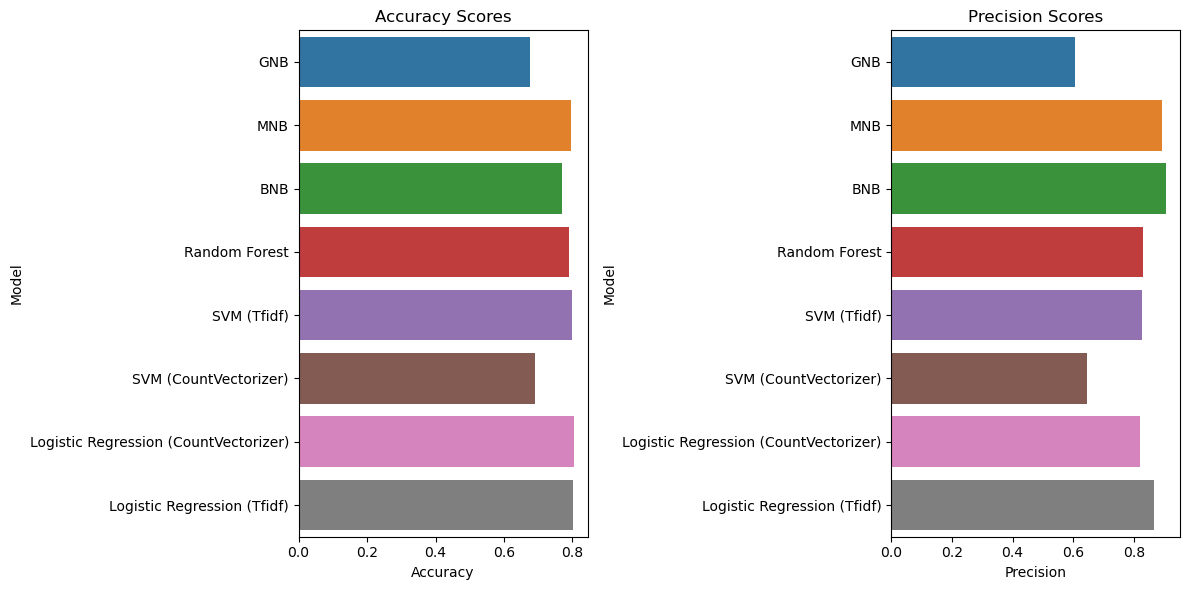

In [64]:
import seaborn as sns
#Define the models and their corresponding predictions
models = ['GNB', 'MNB', 'BNB', 'Random Forest', 'SVM (Tfidf)', 'SVM (CountVectorizer)', 'Logistic Regression (CountVectorizer)', 'Logistic Regression (Tfidf)']
predictions = [ypred1, ypred2, ypred3, ypred4, ypred5, ypred6, y_pred_logreg, y_pred_logreg_tfidf]

# Initialize lists to store accuracy and precision scores
accuracy_scores = []
precision_scores = []

# Calculate accuracy and precision scores for each model
for y_pred in predictions:
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores.append(precision_score(y_test, y_pred))

# Create a DataFrame for easy plotting
df = pd.DataFrame({'Model': models, 'Accuracy': accuracy_scores, 'Precision': precision_scores})

# Plotting
plt.figure(figsize=(12, 6))

# Plot accuracy scores
plt.subplot(1, 2, 1)
sns.barplot(x='Accuracy', y='Model', data=df)
plt.title('Accuracy Scores')

# Plot precision scores
plt.subplot(1, 2, 2)
sns.barplot(x='Precision', y='Model', data=df)
plt.title('Precision Scores')

plt.tight_layout()
plt.show()

# Conclusion 
# The best model we can see is bnb with tf-idf because of high precision and accuracy score so choosing BernoulliNB model 

In [57]:
import pickle
pickle.dump(Tfidf,open('vectorizer.pkl','wb'))
pickle.dump(bnb,open('model.pkl','wb'))